In [1]:
import pandas as pd
import numpy as np
import nltk


In [2]:
from gensim.models import Word2Vec

In [3]:

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [4]:
# Ensure nltk dependencies are available
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Load dataset
train = pd.read_csv('../date/train_data_cleaned.csv')
test = pd.read_csv('../date/test_data_cleaned.csv')
val = pd.read_csv('../date/val_data_cleaned.csv')


In [6]:
import nltk
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
# Funcția de preprocesare
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(tokens)

In [8]:
# Aplică preprocesarea pe coloanele de interes
train['processed_text'] = train['text'].apply(preprocess_text)
train['processed_title'] = train['title'].apply(preprocess_text)

val['processed_text'] = val['text'].apply(preprocess_text)
val['processed_title'] = val['title'].apply(preprocess_text)

test['processed_text'] = test['text'].apply(preprocess_text)
test['processed_title'] = test['title'].apply(preprocess_text)


In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Combină textul și titlul
train['combined_text'] = train['processed_title'] + " " + train['processed_text']
val['combined_text'] = val['processed_title'] + " " + val['processed_text']
test['combined_text'] = test['processed_title'] + " " + test['processed_text']

In [10]:
# Pregătirea datelor pentru model
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['combined_text'])

# Transformă textele în secvențe
X_train = tokenizer.texts_to_sequences(train['combined_text'])
X_val = tokenizer.texts_to_sequences(val['combined_text'])
X_test = tokenizer.texts_to_sequences(test['combined_text'])

In [11]:
# Aplică padding
max_length = 100
X_train_pad = pad_sequences(X_train, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test, maxlen=max_length, padding='post')

# Pregătire etichete
y_train = train['label']
y_val = val['label']
y_test = test['label']

In [12]:
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

# Antrenează un model Word2Vec
w2v_model = Word2Vec(sentences=[text.split() for text in train['combined_text']], vector_size=100, window=5, min_count=1, workers=4)

In [13]:
# Creează matricea de embedding
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]


In [14]:
# Construiește modelul RNN
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=max_length, trainable=False),
    Bidirectional(LSTM(256, return_sequences=True)),
    Dropout(0.5),
    LSTM(128),
    Dense(128, activation='relu', kernel_regularizer='l2'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [15]:
from tensorflow.keras.optimizers import AdamW

optimizer = AdamW(learning_rate=0.001, weight_decay=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Creează callback-uri
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitorizează accuracy pe setul de validare
    patience=3,              # Așteaptă 3 epoci fără îmbunătățire
    restore_best_weights=True  # Reîncarcă greutățile celui mai bun model
)

model_checkpoint = ModelCheckpoint(
    'best_model.h5',  # Salvează cel mai bun model într-un fișier
    monitor='val_accuracy',  # Monitorizează accuracy pe setul de validare
    save_best_only=True,     # Salvează doar dacă modelul este mai bun
    verbose=1
)

In [17]:
# Antrenează modelul
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=20,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint]  # Adaugă callback-urile
)

# Încarcă cel mai bun model salvat
from tensorflow.keras.models import load_model
best_model = load_model('best_model.h5')

# Predicții folosind cel mai bun model
y_pred = (best_model.predict(X_test_pad) > 0.5).astype('int32')

# Evaluare
from sklearn.metrics import accuracy_score, classification_report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Epoch 1/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.7260 - loss: 1.3480
Epoch 1: val_accuracy improved from -inf to 0.79867, saving model to best_model.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 53s 320ms/step - accuracy: 0.7263 - loss: 1.3457 - val_accuracy: 0.7987 - val_loss: 0.6117
Epoch 2/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.7765 - loss: 0.5938
Epoch 2: val_accuracy improved from 0.79867 to 0.82529, saving model to best_model.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 48s 318ms/step - accuracy: 0.7766 - loss: 0.5935 - val_accuracy: 0.8253 - val_loss: 0.4358
Epoch 3/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.8399 - loss: 0.4231
Epoch 3: val_accuracy improved from 0.82529 to 0.85025, saving model to best_model.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 81s 313ms/step - accuracy: 0.8399 - loss: 0.4230 - val_accuracy: 0.8502 - val_loss: 0.3726
Epoch 4/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.8630 - loss: 0.3535
Epoch 4: val_accuracy did not improve from 0.85025
151/151 ━━━━━━━━━━━━━━━━━━━━ 46s 304ms/step - accuracy: 0.8630 - loss: 0.3535 - val_accuracy: 0.8087 - val_loss: 0.4397
Epoch 5/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.8701 - loss: 0.3442
Epoch 5: val_accuracy did not improve from 0.85025
151/151 ━━━━━━━━━━━━━━━━━━━━ 47s 311ms/step - accuracy: 0.8701 - loss: 0.3441 - val_accuracy: 0.8436 - val_loss: 0.3550
Epoch 6/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8636 - loss: 0.3380
Epoch 6: val_accuracy improved from 0.85025 to 0.85358, saving model to best_model.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 48s 317ms/step - accuracy: 0.8637 - loss: 0.3379 - val_accuracy: 0.8536 - val_loss: 0.3546
Epoch 7/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.8935 - loss: 0.2906
Epoch 7: val_accuracy did not improve from 0.85358
151/151 ━━━━━━━━━━━━━━━━━━━━ 45s 294ms/step - accuracy: 0.8935 - loss: 0.2906 - val_accuracy: 0.8536 - val_loss: 0.3548
Epoch 8/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.8909 - loss: 0.2784
Epoch 8: val_accuracy did not improve from 0.85358
151/151 ━━━━━━━━━━━━━━━━━━━━ 43s 288ms/step - accuracy: 0.8909 - loss: 0.2784 - val_accuracy: 0.8519 - val_loss: 0.3367
Epoch 9/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9053 - loss: 0.2509
Epoch 9: val_accuracy improved from 0.85358 to 0.87188, saving model to best_model.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 47s 311ms/step - accuracy: 0.9054 - loss: 0.2509 - val_accuracy: 0.8719 - val_loss: 0.3168
Epoch 10/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.9157 - loss: 0.2263
Epoch 10: val_accuracy did not improve from 0.87188
151/151 ━━━━━━━━━━━━━━━━━━━━ 45s 297ms/step - accuracy: 0.9157 - loss: 0.2263 - val_accuracy: 0.8569 - val_loss: 0.3344
Epoch 11/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.9270 - loss: 0.2044
Epoch 11: val_accuracy did not improve from 0.87188
151/151 ━━━━━━━━━━━━━━━━━━━━ 45s 296ms/step - accuracy: 0.9270 - loss: 0.2045 - val_accuracy: 0.8552 - val_loss: 0.3154
Epoch 12/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.9420 - loss: 0.1772
Epoch 12: val_accuracy did not improve from 0.87188
151/151 ━━━━━━━━━━━━━━━━━━━━ 45s 296ms/step - accuracy: 0.9420 - loss: 0.1773 - val_accuracy: 0.8669 - val_loss: 0.3203


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step
Accuracy: 0.8685524126455907
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       320
           1       0.90      0.81      0.85       281

    accuracy                           0.87       601
   macro avg       0.87      0.87      0.87       601
weighted avg       0.87      0.87      0.87       601



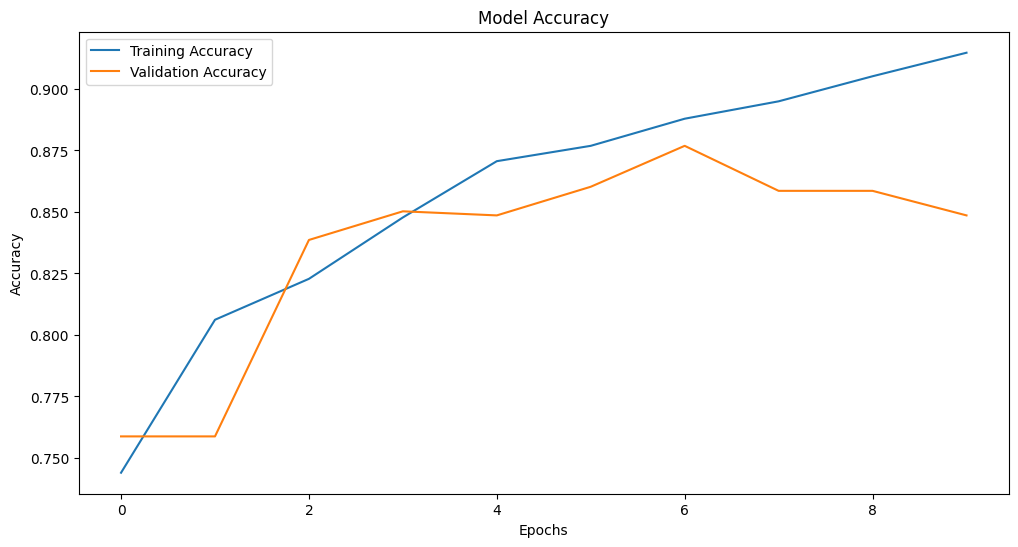

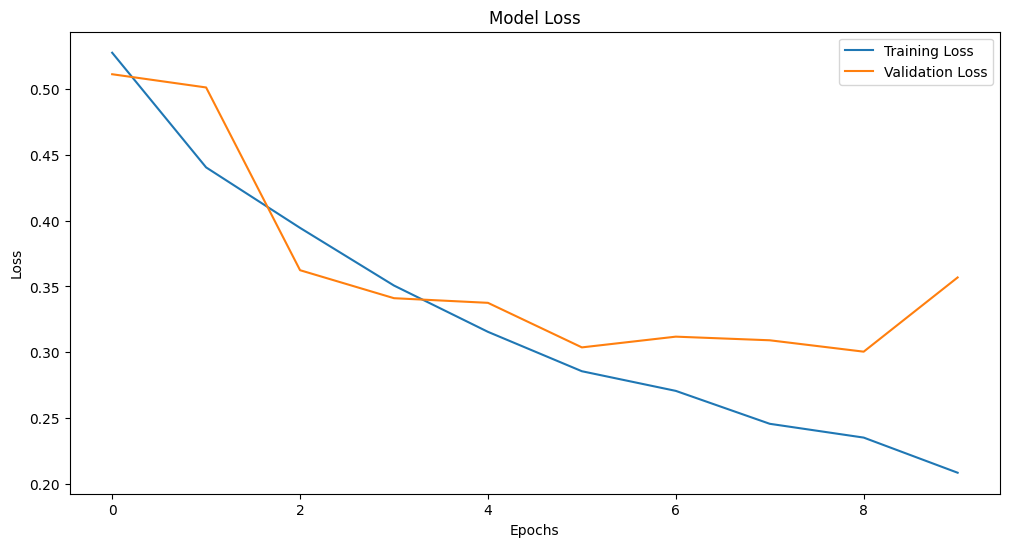

In [57]:
import matplotlib.pyplot as plt

# Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

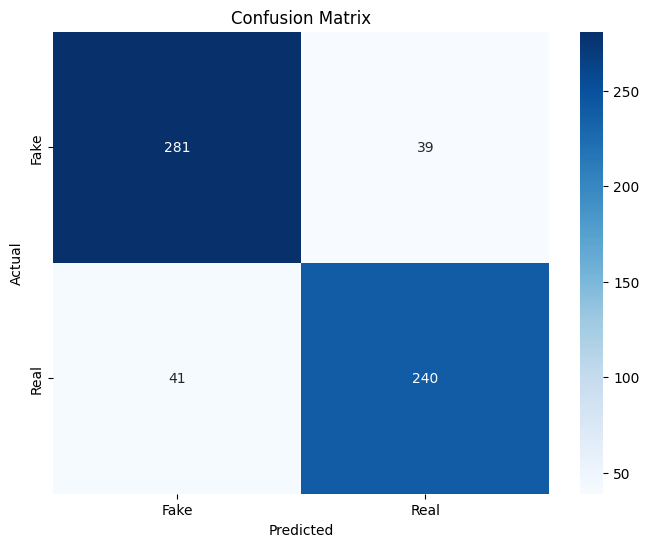

In [58]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


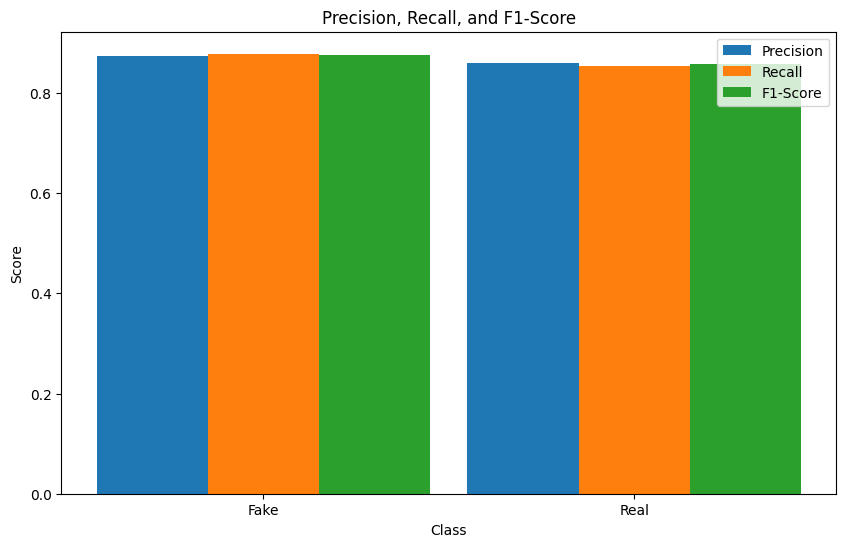

In [59]:
from sklearn.metrics import precision_recall_fscore_support

# Get precision, recall, f1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)

# Bar plot for metrics
labels = ['Fake', 'Real']
x = np.arange(len(labels))

plt.figure(figsize=(10, 6))
width = 0.3
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1_score, width, label='F1-Score')

plt.title('Precision, Recall, and F1-Score')
plt.xlabel('Class')
plt.ylabel('Score')
plt.xticks(x, labels)
plt.legend()
plt.show()


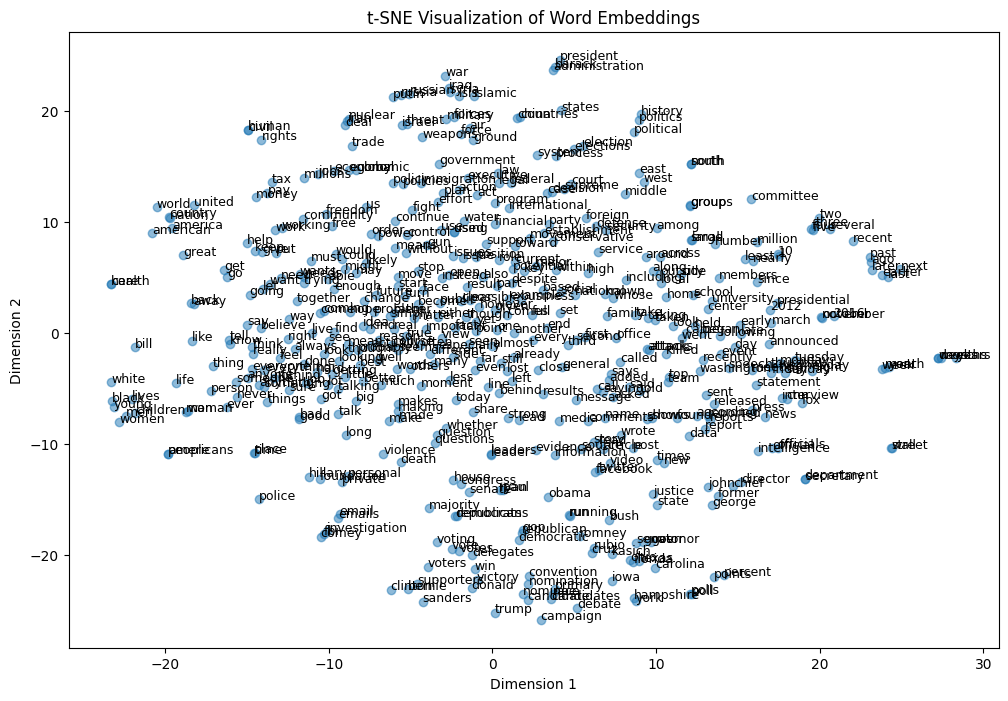

In [60]:
from sklearn.manifold import TSNE

# Extract word vectors and corresponding words
words = list(w2v_model.wv.index_to_key)
word_vectors = w2v_model.wv[words]

# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=42)
word_vectors_2d = tsne.fit_transform(word_vectors[:500])  # Visualize top 500 words

# Plot t-SNE results
plt.figure(figsize=(12, 8))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], alpha=0.5)
for i, word in enumerate(words[:500]):
    plt.text(word_vectors_2d[i, 0], word_vectors_2d[i, 1], word, fontsize=9)
plt.title('t-SNE Visualization of Word Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()